# Ethanol uptake triggers upregulation of tryptophan synthesis 

In [154]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [155]:
from cobra_utils.query.analyzer import ModelAnalyzer 

In [150]:
ma = ModelAnalyzer(bsub)

In [153]:
ma.model.solution

<Solution 0.12 at 0x7facd1fbb2b0>

Load

In [ ]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

In [4]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

## RNASeq data

In [33]:
data = pd.read_csv('rna_seq/RNAseq_raw.csv',index_col=1)

RNAseq data appears to be normalized. That means that roughly they have the same numbre of cells.

In [34]:
samples = data.columns
control_data = data[samples[samples.str.contains('BMM_')]]
stress_data = data[samples[samples.str.contains('Etha_')]]
fold_change = np.divide(stress_data,control_data)

### Tryptophan biosynthesis

Text(0.5, 1.0, 'Tryptophan biosynthetic gene expression')

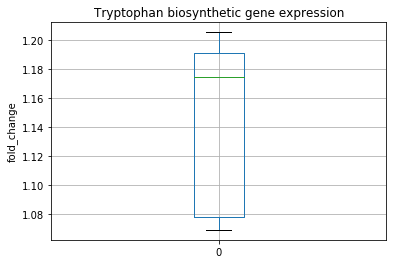

In [60]:
genes = ['trpE','trpD','trpC','trpF','trpB']
fold_change.loc[gene_dictionary.loc[genes]['locus_id']].mean(axis=1).to_frame().boxplot()
plt.ylabel('fold_change')
plt.title('Tryptophan biosynthetic gene expression')

In [59]:
fold_change.loc[gene_dictionary.loc[genes]['locus_id']].mean(axis=1)

Locus_tag
BSU22630    0.924450
BSU22680    1.205198
BSU22670    1.190771
BSU22660    1.174073
BSU22650    1.068800
BSU22640    1.077414
BSU22620    0.904360
BSU22610    0.889177
BSU25660    0.777226
dtype: float64

In [55]:
genes  = ['trpA','trpE', 'trpD', 'trpC', 'trpF', 'trpB', 'hisC', 'tyrA', 'aroE']

In [56]:
from scipy.stats import ttest_ind,t
alpha = 0.05
decision_df = pd.DataFrame(index=control_data.index,columns=['reg'])
for g in tqdm(genes):
    
    a = control_data.loc[gene_dictionary.loc[g]['locus_id']].values
    b = stress_data.loc[gene_dictionary.loc[g]['locus_id']].values
    tval = ttest_ind(a,b).statistic
    pval = t.cdf(tval,df=(len(a)-1)+(len(b)-1))
    print(g,a,b,pval)



100%|██████████| 9/9 [00:00<00:00, 103.58it/s]

trpA [14.9471 14.4796 14.2203] [13.7324 13.0061 13.6   ] 0.988376684405352
trpE [13.7082 11.1219 11.6927] [14.776  14.1919 14.7523] 0.02053958837316
trpD [13.3952 10.2597 11.1506] [14.1372 12.9436 13.9976] 0.05310772061124818
trpC [13.8722 10.738  12.1186] [14.3615 13.8664 14.4891] 0.04875748554257644
trpF [15.9151 13.3491 14.0439] [15.3519 15.3676 15.316 ] 0.15058685232714808
trpB [14.0833 11.1887 12.5295] [13.9477 12.8395 13.7114] 0.18758457901799905
hisC [15.0331 14.5786 14.6321] [13.5769 12.9252 13.5107] 0.9975020651229264
tyrA [14.6288 14.3846 14.1554] [12.8112 12.7625 12.8042] 0.9998428605671983
aroE [13.2929 13.1069 13.1353] [10.3232 10.002  10.4028] 0.9999865836895073


Arginine biosynthesis is downregulated in salt stress.

### Transporter expression

Ethanol transporters are not defined yet in the annotation.

### Up and downregulation

In [44]:
from scipy.stats import ttest_ind,t
alpha = 0.05
decision_df = pd.DataFrame(index=control_data.index,columns=['reg'])
for gene in tqdm(decision_df.index):
    
    a = control_data.loc[gene]
    b = stress_data.loc[gene]
    tval = ttest_ind(b,a).statistic

    pval = t.cdf(tval,df=(len(a)-1)+(len(b)-1))
    if pval > 0.95: # b>a?
        decision_df.loc[gene]['reg'] = 1
    elif pval < 0.05: # b<a?
        decision_df.loc[gene]['reg'] = -1
    else:
        decision_df.loc[gene]['reg'] = 0


 88%|████████▊ | 5196/5875 [00:15<00:02, 320.53it/s]
KeyboardInterrupt



Text(0.5, 1.0, 'Differential expression')

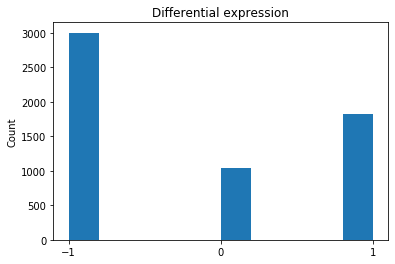

In [8]:
decision_df['reg'].hist(grid=False)
plt.xticks([-1,0,1])
plt.ylabel('Count')
plt.rcParams.update({'font.size':10})
plt.title('Differential expression')

## M simulations

In [9]:
new_glucose_uptake = bsub.solution.x_dict['EX_glc__D_e']*0.5
base_mu = bsub.solution.f

Bacillus subtilis cannot grow in ethanol only

In [10]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
bsub.reactions.get_by_id('EX_etoh_e').lower_bound = -1
bsub.reactions.ETOHt3.lower_bound = -999999.0 # This transporter is reversible in E. coli
bsub.optimize()

<Solution 0.00 at 0x7f684c42f278>

But it can use ethanol as carbon source while using glucose as energy

In [11]:
# Adjust glucose uptake
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = new_glucose_uptake
flux_dict = dict()
# Ethanol uptake rates and simulation
etoh_rates = -np.arange(0,5,0.1)
for rate in etoh_rates:
    bsub.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

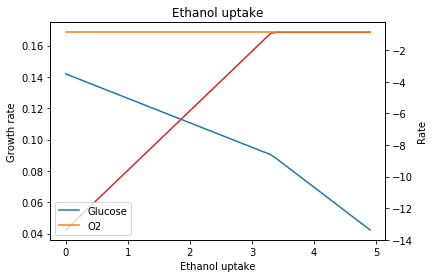

In [12]:
fig,ax1 = plt.subplots()
plt.title('Ethanol uptake')

ax1.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Ethanol uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

Tryptophan production increases, but it could be an artifact of growth rate

Text(0, 0.5, 'Tryptophan production')

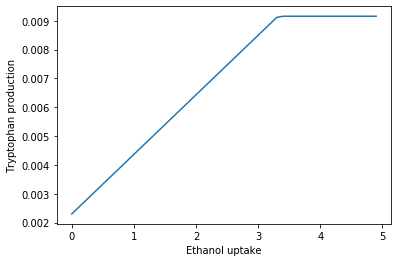

In [13]:
trp_prod = 'TRPS1'
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc[trp_prod])
plt.xlabel('Ethanol uptake')
plt.ylabel('Tryptophan production')

Fix growth rate and calculate by minimization of glucose uptake

In [14]:
# Adjust glucose uptake and fix mu to correct the artifact

bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Ethanol uptake rates and simulation
etoh_rates = -np.arange(0,5,0.1)
flux_responses = dict()
for rate in etoh_rates:
    bsub.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    bsub.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

M-model does not reproduce an increase in Tryptophan production as a result of ethanol processing.

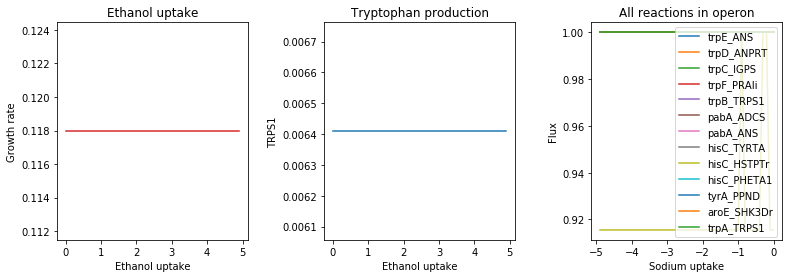

In [15]:
trp_prod = 'TRPS1'

plt.figure(figsize=(13,4))
plt.subplot(1,3,1)

plt.title('Ethanol uptake')
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
plt.xlabel('Ethanol uptake')
plt.ylabel('Growth rate')

plt.subplot(1,3,2)
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc[trp_prod])
plt.xlabel('Ethanol uptake')
plt.ylabel('TRPS1')
plt.title('Tryptophan production')

plt.subplot(1,3,3)
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
genes = ['trpE','trpD','trpC','trpF','trpB','pabA','hisC','tyrA','aroE','trpA']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(etoh_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('All reactions in operon')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

plt.subplots_adjust(wspace=0.4)

M-model does not capture changes in tryptophan synthesis

## ME-model simulations of ethanol uptake

In [156]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [170]:
bsub.solution.y[[m.id for m in bsub.metabolites].index('4abz_c')]

-0.12056313374144563

In [178]:
for met,sp in zip(bsub.metabolites,bsub.solution.y):
    if sp < -50:
        print(met.id,met.name,sp)

12dag3p_BS_c 1 2 diacyl sn glycerol 3 phosphate C3436H6572O800P100 -72.8423905891393
12dgr_BS_c 1 2 diacylglycerol C3436H6672O500 -72.74964971703048
cdlp_BS_c Cardiolipin  B subtilis  C7172H13744O1700P200 -152.82582833065652
cdpdag_BS_c CDPdiacylglycerol  B subtilis  C4336H7772N300O1500P200 -88.23737535920081
d12dg_BS_c Diglucosyl 1 2 diacylglycerol C4636H8672O1500 -92.03975111566179
lipo1_24_BS_c Lipoteichoic acid  n24   linked  glucose substituted C26236H47072O25500P2400 -472.6482902501948
lipo2_24_BS_c Lipoteichoic acid  n24   linked  N acetyl D glucosamine C31036H54272N2400O25500P2400 -550.5506228215904
lipo3_24_BS_c Lipoteichoic acid  n24   linked  D alanine substituted C19036H39872N2400O18300P2400 -359.13346278901844
lipo4_24_BS_c Lipoteichoic acid  n24   linked  unsubstituted C11836H23072O13500P2400 -241.16707346661912
lysylpgly_BS_c Lysylphophatidylglycerol C4336H8572N200O1100P100 -90.37041541770331
m12dg_BS_c Monoglucosyl 1 2 diacylglycerol C4036H7672O1000 -82.39470041634613
p

In [84]:
# new_mu = 0.9*me.solution.f
new_mu = False
me.reactions.biomass_dilution.upper_bound = me.solution.f

In [85]:
# Ethanol can be imported through diffusion
osm_rxn = me.reactions.get_by_id('ETOHtex_FWD_SPONT')
osm_rxn.lower_bound=0
osm_rxn.upper_bound=1000
print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   

ETOHtex_FWD_SPONT 0 1000 etoh_e <=> etoh_c


In [86]:
bsub.reactions.ABTt_1.name

'L arabinitol transport via passive diffusion'

In [20]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    me.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [21]:
etoh_rates = -np.arange(0,0.6,0.1)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5]
Calculating with 6 cores


,-0.5,-0.4,-0.3,-0.2,-0.1,-0.0
biomass_dilution,0.101699,0.101699,0.101699,0.101699,0.101699,0.101699
protein_biomass_to_biomass,0.026734,0.026710,0.028246,0.030720,0.033221,0.035778
mRNA_biomass_to_biomass,0.000096,0.000095,0.000100,0.000106,0.000112,0.000118
tRNA_biomass_to_biomass,0.000566,0.000566,0.000605,0.000644,0.000681,0.000717
rRNA_biomass_to_biomass,0.004182,0.004179,0.004372,0.004654,0.004924,0.005185


In [22]:
flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'acald_c',verbose=False)]]

,-0.5,-0.4,-0.3,-0.2,-0.1,-0.0
DRPA_REV_BSU39420-MONOMER,0.020211,0.020227,0.019264,0.01773,0.016182,0.00493
ALCD2y_FWD_BSU27010-MONOMER,0.500000,0.400000,0.300000,0.20000,0.100000,0.00000
ALDD2x_FWD_BSU38830-MONOMER,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
ALCD2y_FWD_CPLX8J2-194,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
ETHAAL_FWD_CPLX_dummy,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
ALDD2x_FWD_BSU39860-MONOMER,0.479789,0.379773,0.280736,0.18227,0.083818,0.00000
ALCD2y_FWD_BSU26970-MONOMER,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
ALCD2y_REV_BSU27010-MONOMER,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
ALDD2x_FWD_BSU19310-MONOMER,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
FDMO1_FWD_BSU08860-MONOMER,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000


In [184]:
bsub.solver = 'gurobi'

In [23]:
# Save results
flux_responses_me.to_csv('stress_cases/ethanol_flux_responses.csv',index_label='rxn_id')

In [179]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
flux_responses_me = pd.read_csv('stress_cases/ethanol_flux_responses.csv',index_col=0)

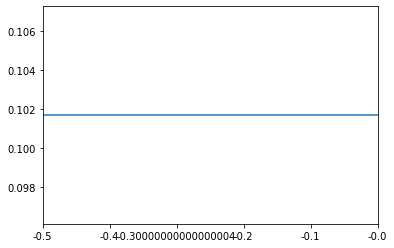

In [180]:
flux_responses_me.loc['biomass_dilution'].plot()

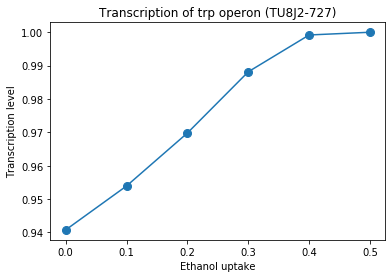

In [25]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of trp operon (TU8J2-727)')
plt.ylabel('Transcription level')
plt.xlabel('Ethanol uptake')
plt.savefig('figures/ethanol_trp_response.svg',format='SVG')

Tryptophan production appears to increase with ethanol uptake.

Text(0.5, 1.0, 'promoter')

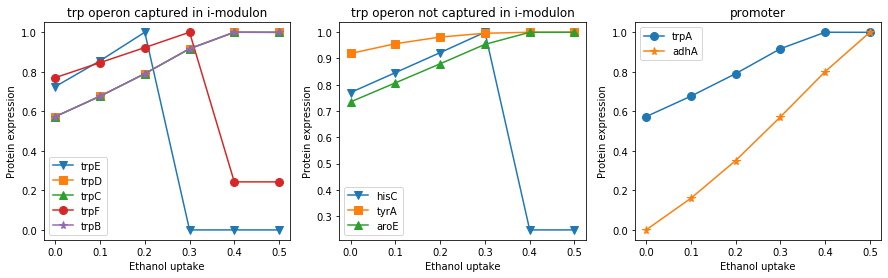

In [26]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

plt.subplot(1,3,1)

genes = ['trpE','trpD','trpC','trpF','trpB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon captured in i-modulon')

plt.subplot(1,3,2)
genes = ['hisC','tyrA','aroE']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon not captured in i-modulon')

plt.subplot(1,3,3)
genes = ['trpA','adhA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('promoter')


Text(0.5, 1.0, 'promoter')

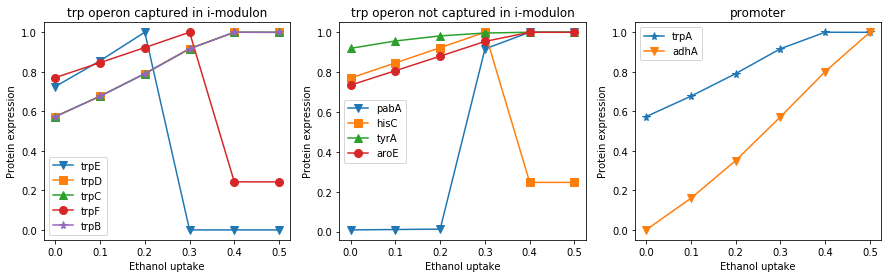

In [27]:
# Normalized by growth rate (yield)
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

plt.subplot(1,3,1)

genes = ['trpE','trpD','trpC','trpF','trpB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]/flux_responses_me.loc['biomass_dilution']
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon captured in i-modulon')

plt.subplot(1,3,2)
genes = ['pabA','hisC','tyrA','aroE']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]/flux_responses_me.loc['biomass_dilution']
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon not captured in i-modulon')

plt.subplot(1,3,3)
genes = ['trpA','adhA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]/flux_responses_me.loc['biomass_dilution']
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('promoter')


There is a clear trend of upregulation of tryptophan synthesis being captured by the model.

Notes:
* Ethanol diffuses through the membrane (passive transport).


In [28]:
df = flux_responses_me.loc[flux_responses_me.index.str.contains('EX_')]

In [29]:
df2=df[(abs(df).select_dtypes(include=['number']) > 1e-15).any(1)]
df2 = df2.loc[df2.index.str.contains('_e')]
df2

,-0.5,-0.4,-0.30000000000000004,-0.2,-0.1,-0.0
rxn_id,,,,,,
EX_ac_e,2.093158e-01,5.422911e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_co2_e,6.688965e+00,6.799696e+00,6.700425e+00,6.481959e+00,6.262592e+00,6.042004e+00
EX_cobalt2_e,-6.671558e-08,-6.669826e-08,-6.363556e-08,-5.869483e-08,-5.384421e-08,-4.901670e-08
EX_etoh_e,-5.000000e-01,-4.000000e-01,-3.000000e-01,-2.000000e-01,-1.000000e-01,-0.000000e+00
EX_glc__D_e,-1.699825e+00,-1.699859e+00,-1.700000e+00,-1.700000e+00,-1.700000e+00,-1.700000e+00
EX_h2o_e,9.378015e+00,9.388270e+00,9.217326e+00,8.948235e+00,8.679649e+00,8.412219e+00
EX_h_e,8.712453e-01,7.159333e-01,6.825491e-01,7.166302e-01,7.500808e-01,7.829817e-01
EX_k_e,-2.938586e-07,-2.942209e-07,-2.731779e-07,-2.411101e-07,-2.105910e-07,-1.808770e-07
EX_mg2_e,-4.903847e-04,-4.899858e-04,-6.232528e-04,-8.563450e-04,-1.084799e-03,-1.309071e-03


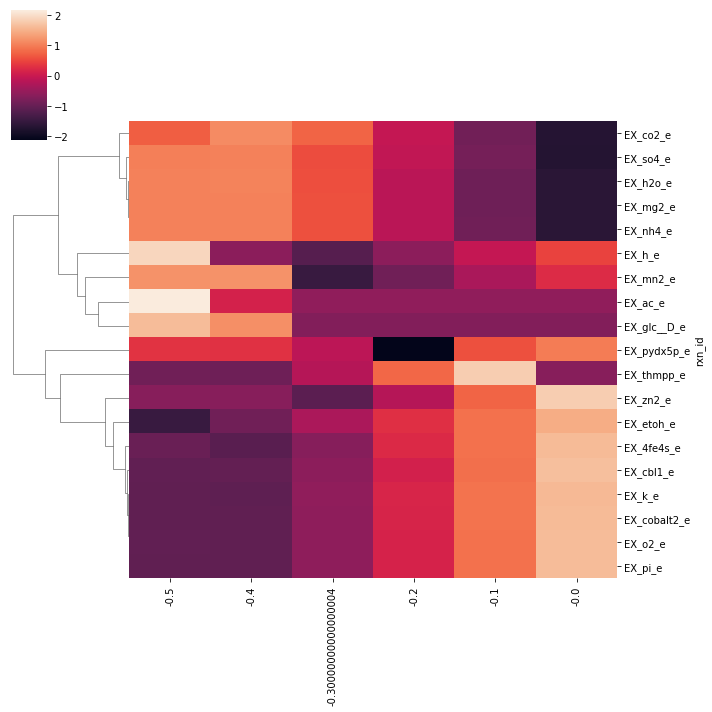

In [30]:
import seaborn as sns
from scipy import stats
a = pd.DataFrame(data=stats.zscore(df2,axis=1),
                 index=df2.index,columns=df2.columns)
sns.clustermap(a,col_cluster = False)

## Accuracy of prediction of transcription response

In [31]:
transcription_response = flux_responses_me.loc[flux_responses_me.index.str.contains('translation')]
all_genes = [gene.split('_')[1] for gene in transcription_response.index]
transcription_df = pd.DataFrame(data=transcription_response.values,index=all_genes,columns=transcription_response.columns)
# Only expressed genes
#transcription_df = transcription_df[transcription_df.any(axis=1)]

In [32]:
# Normalized by growth rate
#transcription_df = transcription_df.div(flux_responses_me.loc['biomass_dilution'])

In [33]:
transcription_df

,-0.5,-0.4,-0.30000000000000004,-0.2,-0.1,-0.0
BSU00090,2.296563e-08,2.298990e-08,2.148083e-08,1.918348e-08,1.695541e-08,1.478195e-08
BSU00110,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
BSU00120,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
BSU00130,1.153742e-08,1.152847e-08,1.172144e-08,1.188162e-08,1.184689e-08,1.161281e-08
BSU00140,1.651446e-08,1.653980e-08,1.499621e-08,1.269506e-08,1.056977e-08,0.000000e+00
...,...,...,...,...,...,...
BSU40890,2.860852e-06,2.858513e-06,2.983918e-06,3.176731e-06,3.361232e-06,3.539011e-06
BSU40910,2.860852e-06,2.858513e-06,2.983918e-06,3.176731e-06,3.361232e-06,3.539011e-06
BSU41050,2.851711e-13,2.849320e-13,2.869930e-13,2.899953e-13,2.924735e-13,2.944145e-13
BSU41060,2.860852e-06,2.858513e-06,2.983918e-06,3.176731e-06,3.361232e-06,3.539011e-06


What should be the threshold to identify up or downregulation in the model?

In [34]:
thresholds = np.arange(0,0.05,0.001)
accuracies = pd.DataFrame(index=thresholds,columns=['TPR','FNR','FDR','prec'])
for threshold in thresholds:

    predicted_fold_change = ((transcription_df['-0.5']-transcription_df['-0.0'])/transcription_df.max(axis=1))
    predicted_fold_change = predicted_fold_change.fillna(0)

    upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
    downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
    rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

    predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
    predicted_decision.loc[upregulated_genes.index]= 1
    predicted_decision.loc[downregulated_genes.index] = -1

    decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
    
    
    # Metrics
    P = decision_results[decision_results['reg_rna'] != 0].index
    F = decision_results[decision_results['reg_rna'] == 0].index
    pP = decision_results[decision_results['reg_me'] != 0].index
    pF = decision_results[decision_results['reg_me'] == 0].index

    TP = len(decision_results[decision_results['reg_rna']==decision_results['reg_me']][decision_results['reg_rna'] != 0])
    FP = len(pP)-TP
    TN = len(decision_results[decision_results['reg_rna']==decision_results['reg_me']][decision_results['reg_rna'] == 0])
    FN = len(pF)-TN

    TPR = TP/(TP+FN)
    FNR = TN/(TN+FP)

    prec = TP/(TP+FP)
    FDR = 1-prec
    MCC = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    
    accuracies.loc[threshold]['TPR'] = TPR
    accuracies.loc[threshold]['FNR'] = FNR
    accuracies.loc[threshold]['FDR'] = FDR
    accuracies.loc[threshold]['prec'] = prec

    correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
    incorrect = len(decision_results.index)-correct

    accuracy = correct/len(decision_results.index)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:25 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:27 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0, 0.5, 'Metric')

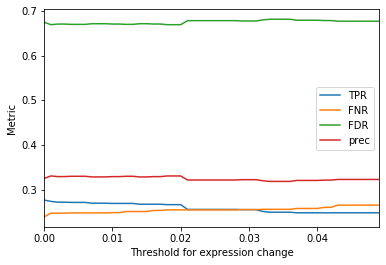

In [35]:
accuracies.plot()
plt.xlabel('Threshold for expression change')
plt.ylabel('Metric')

Seems like the model is able to capture regulation with small changes. Threshold of 0 is the best for accuracy.

In [36]:
threshold = 0.
predicted_fold_change = ((transcription_df['-0.5']-transcription_df['-0.0'])/transcription_df['-0.0'])

upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
predicted_decision.loc[upregulated_genes.index]= 1
predicted_decision.loc[downregulated_genes.index] = -1

decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
decision_results

correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
incorrect = len(decision_results.index)-correct

accuracy = correct/len(decision_results.index)

In [37]:
correct_df = decision_results[decision_results.reg_me==decision_results.reg_rna]
incorrect_df = decision_results[decision_results.reg_me!=decision_results.reg_rna]

In [38]:
df = correct_df['reg_me'].value_counts().to_frame().join(incorrect_df['reg_me'].value_counts().to_frame(),rsuffix='_i')

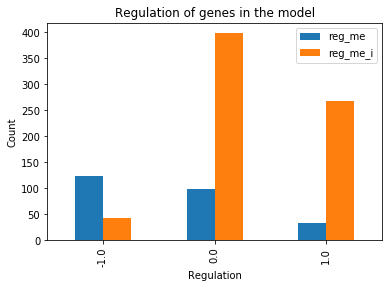

In [39]:
df.plot.bar()
plt.xlabel('Regulation')
plt.ylabel('Count')
plt.title('Regulation of genes in the model')
plt.savefig('figures/ethanol_regulated_genes.svg',format='SVG')

In [40]:
gene_name = 'trpC'
get_reactions_of_met(me,'{}-MONOMER'.format(gene_dictionary.loc[gene_name]['locus_id']))

( IGPS_FWD_BSU22660-MONOMER 0 999999.0 ) 	 2cpr5p_c + 1.64645664343155e-5*mu BSU22660-MONOMER + h_c <=> 3ig3p_c + co2_c + h2o_c
( formation_BSU22660-MONOMER 0.0 1000.0 ) 	 protein_BSU22660 --> BSU22660-MONOMER


[<MetabolicReaction IGPS_FWD_BSU22660-MONOMER at 0x7f683f007e10>,
 <ComplexFormation formation_BSU22660-MONOMER at 0x7f683f65ae48>]

In [41]:
for r in me.reactions:
    if 'LAAL34' in r.id:
        print(r.id)

LAAL34_FWD_BSU37710-MONOMER


In [42]:
rxns = get_reactions_of_met(me,'trp__L_c',verbose=False)

In [43]:
rxn_ids=[]
_= [rxn_ids.append(r.id) for r in rxns]

In [44]:
flux_responses_me.loc[rxn_ids].sort_values(by='-0.5',ascending=False)

,-0.5,-0.4,-0.30000000000000004,-0.2,-0.1,-0.0
rxn_id,,,,,,
TRPS1_FWD_CPLX8J2-19_mod_pydx5p,0.005602,0.005600,0.005391,0.005055,0.004742,0.004454
charging_tRNA_BSU_tRNA_38_UGG,0.005602,0.005600,0.005391,0.005055,0.004742,0.004454
translation_dummy,0.000441,0.000440,0.000466,0.000506,0.000548,0.000590
translation_BSU22560,0.000112,0.000112,0.000104,0.000091,0.000079,0.000068
translation_BSU22540,0.000112,0.000112,0.000104,0.000091,0.000079,0.000068
...,...,...,...,...,...,...
translation_BSU35609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translation_BSU38280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translation_BSU19350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
flux_responses_me.loc[rxn_ids].sort_values(by='-0.5',ascending=False).head(20)

,-0.5,-0.4,-0.30000000000000004,-0.2,-0.1,-0.0
rxn_id,,,,,,
TRPS1_FWD_CPLX8J2-19_mod_pydx5p,0.005602,0.005600,0.005391,0.005055,0.004742,0.004454
charging_tRNA_BSU_tRNA_38_UGG,0.005602,0.005600,0.005391,0.005055,0.004742,0.004454
translation_dummy,0.000441,0.000440,0.000466,0.000506,0.000548,0.000590
translation_BSU22560,0.000112,0.000112,0.000104,0.000091,0.000079,0.000068
translation_BSU22540,0.000112,0.000112,0.000104,0.000091,0.000079,0.000068
translation_BSU22550,0.000112,0.000112,0.000104,0.000091,0.000079,0.000068
translation_BSU14890,0.000066,0.000067,0.000062,0.000054,0.000047,0.000040
translation_BSU14910,0.000066,0.000067,0.000062,0.000054,0.000047,0.000040
translation_BSU14900,0.000066,0.000067,0.000062,0.000054,0.000047,0.000040


In [46]:
df = flux_responses_me.loc[rxn_ids]
df2  = (df['-0.5']-df['-0.0']).sort_values(ascending=False).head(20).drop('charging_tRNA_BSU_tRNA_38_UGG')
df2

rxn_id
TRPS1_FWD_CPLX8J2-19_mod_pydx5p    1.147878e-03
translation_BSU22540               4.412077e-05
translation_BSU22550               4.412077e-05
translation_BSU22560               4.412077e-05
translation_BSU14920               2.620083e-05
translation_BSU14900               2.620083e-05
translation_BSU14890               2.620083e-05
translation_BSU14910               2.620083e-05
translation_BSU36870               5.444024e-06
translation_BSU36880               5.444024e-06
translation_BSU32200               2.771536e-06
translation_BSU38240               2.115719e-06
translation_BSU36510               1.783462e-06
translation_BSU14610               8.974509e-07
translation_BSU12840               8.351581e-07
translation_BSU33940               8.336774e-07
translation_BSU28430               6.423131e-07
translation_BSU28440               6.423131e-07
translation_BSU28450               6.423131e-07
dtype: float64

In [47]:
df2.div(df2.sum())

rxn_id
TRPS1_FWD_CPLX8J2-19_mod_pydx5p    0.815778
translation_BSU22540               0.031356
translation_BSU22550               0.031356
translation_BSU22560               0.031356
translation_BSU14920               0.018621
translation_BSU14900               0.018621
translation_BSU14890               0.018621
translation_BSU14910               0.018621
translation_BSU36870               0.003869
translation_BSU36880               0.003869
translation_BSU32200               0.001970
translation_BSU38240               0.001504
translation_BSU36510               0.001267
translation_BSU14610               0.000638
translation_BSU12840               0.000594
translation_BSU33940               0.000592
translation_BSU28430               0.000456
translation_BSU28440               0.000456
translation_BSU28450               0.000456
dtype: float64

In [48]:
get_reactions_of_met(me,'trp__L_c',only_types=['MetabolicReaction'])

( BIOMASS_BS_10_FWD_CPLX_dummy 0 0 ) 	 0.000367 10fthf_c + 4.27350427350427e-6*mu CPLX_dummy + 0.266902 ala__L_c + 0.00467 amp_c + 0.193021 arg__L_c + 0.147987 asn__L_c + 0.148014 asp__L_c + 105.053483 atp_c + 0.003205 ca2_c + 5e-06 cdlp_BS_c + 0.000251 cdp_c + 0.001042 cmp_c + 0.038902 ctp_c + 0.05699 cys__L_c + 0.00011 d12dg_BS_c + 0.022982 datp_c + 0.01738 dctp_c + 0.017398 dgtp_c + 0.022899 dttp_c + 0.00345 fe3_c + 0.00018 gdp_c + 0.260335 gln__L_c + 0.260378 glu__L_c + 0.408288 gly_c + 0.000503 gmp_c + 0.003624 gtca1_45_BS_c + 0.002347 gtca2_45_BS_c + 0.001819 gtca3_45_BS_c + 0.062667 gtp_c + 105.0 h2o_c + 0.081739 his__L_c + 0.269905 ile__L_c + 0.706312 k_c + 0.346445 leu__L_c + 7e-06 lipo1_24_BS_c + 6e-06 lipo2_24_BS_c + 1.8e-05 lipo3_24_BS_c + 1.5e-05 lipo4_24_BS_c + 0.323093 lys__L_c + 2.2e-05 lysylpgly_BS_c + 8.6e-05 m12dg_BS_c + 0.113326 met__L_c + 0.101714 mg2_c + 0.000266 mql7_c + 0.016164 nad_c + 0.000934 nadp_c + 0.000216 nadph_c + 0.101817 peptido_BS_c + 0.000176 pgly_B

[<MetabolicReaction BIOMASS_BS_10_FWD_CPLX_dummy at 0x7f683f3001d0>,
 <MetabolicReaction LAAL33_FWD_BSU37710-MONOMER at 0x7f683ef94668>,
 <MetabolicReaction LAAL34_FWD_BSU37710-MONOMER at 0x7f683ef94828>,
 <MetabolicReaction TRPS1_FWD_CPLX8J2-19_mod_pydx5p at 0x7f683ed3fbe0>,
 <MetabolicReaction TRPt2r_FWD_BSU10010-MONOMER at 0x7f683ed3fe10>]

In [49]:
flux_responses_me.loc['TRPS1_FWD_CPLX8J2-19_mod_pydx5p']

-0.5                    0.005602
-0.4                    0.005600
-0.30000000000000004    0.005391
-0.2                    0.005055
-0.1                    0.004742
-0.0                    0.004454
Name: TRPS1_FWD_CPLX8J2-19_mod_pydx5p, dtype: float64

In [104]:
def get_met_production(me,met_list,flux_responses_me,x_var):
    fig,ax = plt.subplots(int(np.ceil(np.sqrt(len(met_list)))),int(np.floor(np.sqrt(len(met_list)))),figsize=(13,3*int(np.ceil(np.sqrt(len(met_list))))))
    ax = ax.flatten()
    
    if not isinstance(flux_responses_me,list):
        flux_responses_me = [flux_responses_me]
    
    temp_dict = {}
    for idx,met_id in enumerate(met_list):
        for flux_df in flux_responses_me:
            met_rate = []
            uptake_rate = []
            for case in flux_df.columns:
                df = flux_based_reactions(me,met_id,flux_dict=flux_df[case].to_dict(),only_types=['MetabolicReaction'])
                met_rate.append(df[df.met_flux>0]['met_flux'].sum())
                uptake_rate.append(flux_df.abs()[case][x_var])
            ax[idx].plot(uptake_rate,met_rate,'-o')
            ax[idx].set_xlabel(x_var)
            ax[idx].set_ylabel('mmol {}/gDW/h'.format(met_id))
            ax[idx].set_title(met_id)
    fig.tight_layout()

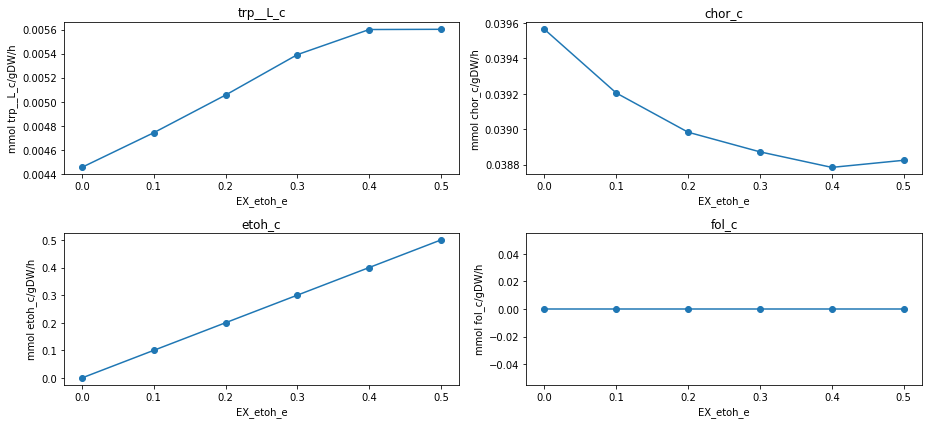

In [106]:
met_list = ['trp__L_c','chor_c','etoh_c','fol_c']
get_met_production(me,met_list,flux_responses_me,'EX_etoh_e')
plt.savefig('figures/ethanol_aa_prod.svg',format='SVG')

### Forcing folate damage

In [87]:
me.reactions.get_by_id('EX_etoh_e').upper_bound = -0.5
etoh_rates = np.arange(0,0.2,0.05)

In [88]:
# Folate damage
r = cobrame.MEReaction('DM_fol_c')
me.add_reaction(r)

r.add_metabolites({'fol_c':-1})
r.lower_bound=0
r.upper_bound=1000
print(r.id,r.lower_bound,r.upper_bound,r.reaction)   

DM_fol_c 0 1000 fol_c <=> 


In [89]:
# Adjust glucose uptake

bsub = cobra.io.load_json_model(ijo_directory)
bsub.optimize()

bsub.reactions.BIOMASS_BS_10.lower_bound = 0.5 * bsub.solution.f
bsub.reactions.BIOMASS_BS_10.upper_bound = 0.5 * bsub.solution.f

flux_dict = dict()
# Ethanol uptake rates and simulation
etoh_rates = np.arange(0,0.2,0.05)
r = cobra.Reaction('DM_fol_c')
bsub.add_reaction(r)
r.add_metabolites({'fol_c':-1})
r.lower_bound=0
r.upper_bound=1000

for rate in etoh_rates:
    bsub.reactions.get_by_id('DM_fol_c').lower_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

In [53]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('DM_fol_c').lower_bound = rate
    me.reactions.get_by_id('DM_fol_c').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [54]:
etoh_rates = np.arange(0,0.2,0.05)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()


Rates to use: [0.   0.05 0.1  0.15]
Calculating with 4 cores


,0.00,0.05,0.10,0.15
biomass_dilution,0.101699,0.101699,0.101699,0.090072
protein_biomass_to_biomass,0.026701,0.027719,0.033494,0.031760
mRNA_biomass_to_biomass,0.000095,0.000098,0.000113,0.000102
tRNA_biomass_to_biomass,0.000565,0.000582,0.000686,0.000622
rRNA_biomass_to_biomass,0.004178,0.004301,0.004956,0.004497


In [55]:
# Save results
flux_responses_me.to_csv('stress_cases/folate_flux_responses.csv',index_label='rxn_id')

In [104]:
flux_responses_me = pd.read_csv('stress_cases/folate_flux_responses.csv',index_col=0)

Text(0.5, 0, 'Folate damage rate')

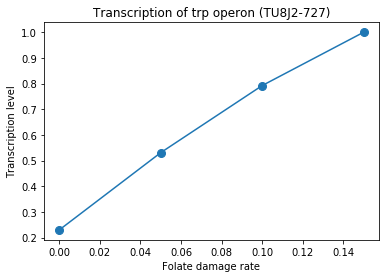

In [105]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(flux_responses_me.loc['DM_fol_c'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of trp operon (TU8J2-727)')
plt.ylabel('Transcription level')
plt.xlabel('Folate damage rate')

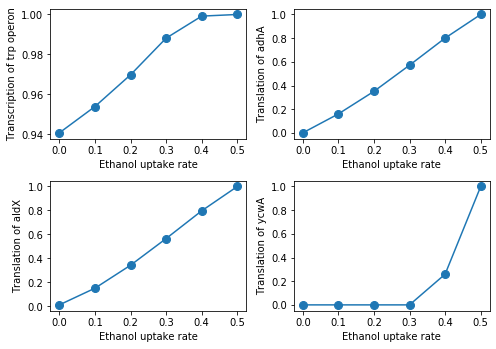

In [58]:
# Visualize transcription profiles
fig,ax = plt.subplots(2,2,figsize=(7,5))
# trp operon is TU8J2-727
flux_responses_me = pd.read_csv('stress_cases/ethanol_flux_responses.csv',index_col=0)

expression = flux_responses_me.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
ax[0,0].plot(-flux_responses_me.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
ax[0,0].set_ylabel('Transcription of trp operon')
ax[0,0].set_xlabel('Ethanol uptake rate')

# trp operon is TU8J2-727
expression = flux_responses_me.loc['translation_BSU27010']
ax[0,1].plot(-flux_responses_me.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
ax[0,1].set_ylabel('Translation of adhA')
ax[0,1].set_xlabel('Ethanol uptake rate')

# trp operon is TU8J2-727
expression = flux_responses_me.loc['translation_BSU39860']
ax[1,0].plot(-flux_responses_me.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
ax[1,0].set_ylabel('Translation of aldX')
ax[1,0].set_xlabel('Ethanol uptake rate')

# trp operon is TU8J2-727
expression = flux_responses_me.loc['translation_BSU38240']
ax[1,1].plot(-flux_responses_me.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
ax[1,1].set_ylabel('Translation of ycwA')
ax[1,1].set_xlabel('Ethanol uptake rate')

plt.tight_layout()
plt.savefig('figures/ethanol_subplots.svg',format='SVG')

In [59]:
me.reactions.get_by_id('transcription_TU8J2_727_from_BSU25200-MONOMER').reaction

'4.27350427350427e-6*mu BSU00550-MONOMER + 4.27350427350427e-6*mu BSU01010-MONOMER + 4.27350427350427e-6*mu BSU16600-MONOMER + 4.27350427350427e-6*mu BSU27320-MONOMER + 4.27350427350427e-6*mu CPLX8J2-30 + 0.0452224832402947*mu + 0.0177046021885754 CPLX8J2-52 + 2422 atp_c + 2351 ctp_c + 1898 gtp_c + 2792 utp_c --> RNA_BSU22600 + RNA_BSU22610 + RNA_BSU22620 + RNA_BSU22630 + RNA_BSU22640 + RNA_BSU22650 + RNA_BSU22660 + RNA_BSU22670 + RNA_BSU22680 + 3013.1968146159998 mRNA_biomass + 9463 ppi_c'

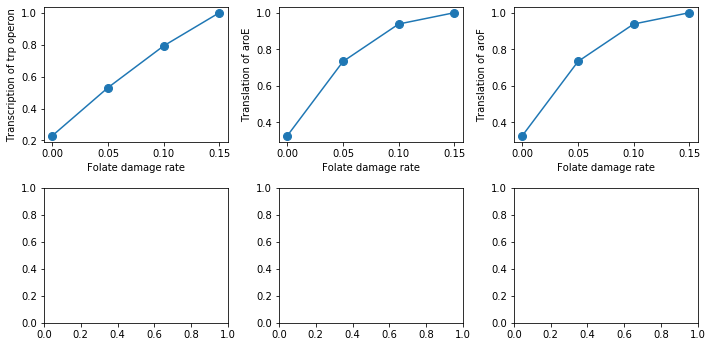

In [60]:
##
fig,ax = plt.subplots(2,3,figsize=(10,5))
flux_responses_me = pd.read_csv('stress_cases/folate_flux_responses.csv',index_col=0)
expression = flux_responses_me.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
ax[0,0].plot(flux_responses_me.loc['DM_fol_c'],
         expression/max(expression),
         marker = 'o',markersize=8)
ax[0,0].set_ylabel('Transcription of trp operon')
ax[0,0].set_xlabel('Folate damage rate')

##
expression = flux_responses_me.loc['translation_BSU22600']
ax[0,1].plot(flux_responses_me.loc['DM_fol_c'],
         expression/max(expression),
         marker = 'o',markersize=8)
ax[0,1].set_ylabel('Translation of aroE')
ax[0,1].set_xlabel('Folate damage rate')

##
expression = flux_responses_me.loc['translation_BSU22710']
ax[0,2].plot(flux_responses_me.loc['DM_fol_c'],
         expression/max(expression),
         marker = 'o',markersize=8)
ax[0,2].set_ylabel('Translation of aroF')
ax[0,2].set_xlabel('Folate damage rate')

plt.tight_layout()
plt.savefig('figures/folate_trp_transcription.svg',format='SVG')

In [61]:
flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'trp__L_c',verbose=False)]].sort_values(by='0.15000000000000002',ascending=False)

,0.0,0.05,0.1,0.15000000000000002
rxn_id,,,,
TRPS1_FWD_CPLX8J2-19_mod_pydx5p,5.599525e-03,0.005828,5.331369e-03,4.465434e-03
charging_tRNA_BSU_tRNA_38_UGG,5.599178e-03,0.005827,5.331058e-03,4.465184e-03
translation_dummy,4.400852e-04,0.000457,5.520119e-04,5.234379e-04
translation_BSU22540,1.123045e-04,0.000116,9.231580e-05,7.137188e-05
translation_BSU22560,1.123045e-04,0.000116,9.231580e-05,7.137188e-05
...,...,...,...,...
translation_BSU08030,0.000000e+00,0.000000,0.000000e+00,-1.629445e-27
translation_BSU09850,0.000000e+00,0.000000,0.000000e+00,-4.747277e-27
translation_BSU09520,0.000000e+00,0.000000,0.000000e+00,-8.415744e-27


In [62]:
df = flux_based_reactions(me,'4adcho_c',flux_dict=flux_responses_me['0.15000000000000002'].to_dict())
df

,lb,ub,rxn_flux,met_flux,reaction
ADCL_FWD_BSU00760-MONOMER,0,999999,0.150033,-0.150033,4adcho_c + 3.95617500794871e-6*mu BSU00760-MON...
ADCS_FWD_CPLX8J2-29,0,999999,0.150033,0.150033,7.81508798303905e-6*mu CPLX8J2-29 + chor_c + g...


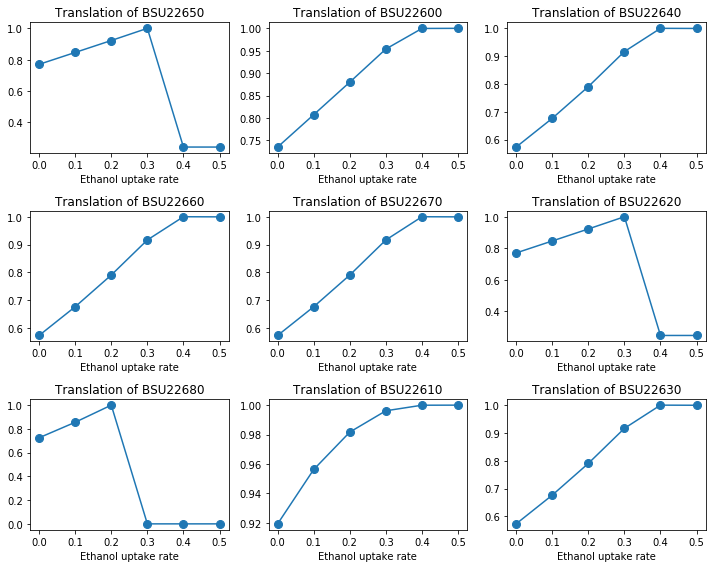

In [63]:
fig,ax = plt.subplots(3,3,figsize=(10,8))
ax = ax.flatten()
flux_responses_me = pd.read_csv('stress_cases/ethanol_flux_responses.csv',index_col=0)
for idx,met in enumerate(me.reactions.get_by_id('transcription_TU8J2_727_from_BSU25200-MONOMER').products):
    if 'RNA_BSU' in met.id:
        gene_id = met.id.split('_')[-1]
        expression = flux_responses_me.loc['translation_'+gene_id]
        ax[idx].plot(-flux_responses_me.loc['EX_etoh_e'],
                 expression/max(expression),
                 marker = 'o',markersize=8)
        ax[idx].set_title('Translation of '+gene_id)
        ax[idx].set_xlabel('Ethanol uptake rate')
plt.tight_layout()
plt.savefig('figures/ethanol_trp_subplots.svg',format='SVG')

In [64]:
for idx,met in enumerate(me.reactions.get_by_id('transcription_TU8J2_727_from_BSU25200-MONOMER').products):
    if 'RNA_BSU' in met.id:
        gene_id = met.id.split('_')[-1]
    for r in get_final_reactions_of_gene(me,gene_id):
        print(r.id, r.reaction)

PRAIi_FWD_BSU22650-MONOMER 1.83261661414514e-5*mu BSU22650-MONOMER + pran_c <=> 2cpr5p_c
PRAIi_REV_BSU22650-MONOMER 2cpr5p_c + 1.83261661414514e-5*mu BSU22650-MONOMER <=> pran_c
PSCVT_FWD_BSU22600-MONOMER 1.14079446337491e-5*mu BSU22600-MONOMER + pep_c + skm5p_c <=> 3psme_c + pi_c
PSCVT_REV_BSU22600-MONOMER 3psme_c + 1.14079446337491e-5*mu BSU22600-MONOMER + pi_c <=> pep_c + skm5p_c
TRPS1_FWD_CPLX8J2-19_mod_pydx5p 3ig3p_c + 4.73113259594653e-6*mu CPLX8J2-19_mod_pydx5p + ser__L_c <=> g3p_c + h2o_c + trp__L_c
IGPS_FWD_BSU22660-MONOMER 2cpr5p_c + 1.64645664343155e-5*mu BSU22660-MONOMER + h_c <=> 3ig3p_c + co2_c + h2o_c
ANPRT_FWD_BSU22670-MONOMER 1.35361847172882e-5*mu BSU22670-MONOMER + anth_c + prpp_c <=> ppi_c + pran_c
TYRTA_REV_BSU22620-MONOMER_mod_pydx5p 34hpp_c + 4.27350427350427e-6*mu BSU22620-MONOMER_mod_pydx5p + glu__L_c <=> akg_c + tyr__L_c
HSTPTr_FWD_BSU22620-MONOMER_mod_pydx5p 7.41858976247727e-6*mu BSU22620-MONOMER_mod_pydx5p + glu__L_c + imacp_c <=> akg_c + h_c + hisp_c
TYRTA

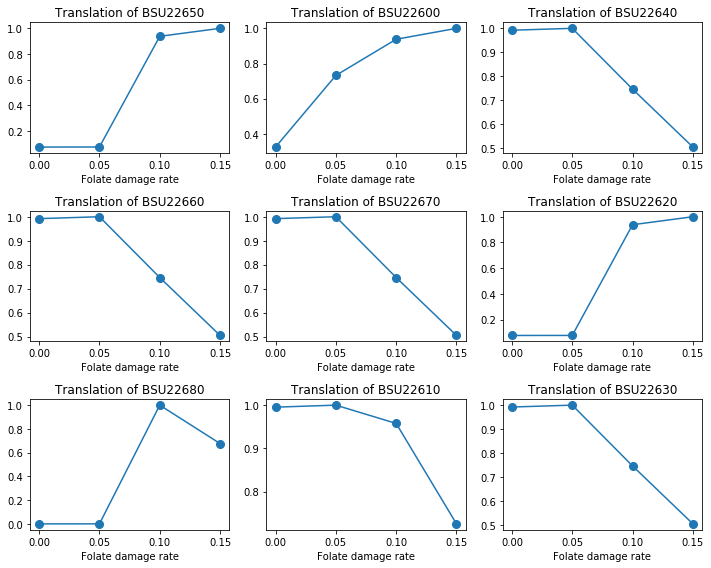

In [65]:
flux_responses_me = pd.read_csv('stress_cases/folate_flux_responses.csv',index_col=0)
fig,ax = plt.subplots(3,3,figsize=(10,8))
ax = ax.flatten()
for idx,met in enumerate(me.reactions.get_by_id('transcription_TU8J2_727_from_BSU25200-MONOMER').products):
    if 'RNA_BSU' in met.id:
        gene_id = met.id.split('_')[-1]
        expression = flux_responses_me.loc['translation_'+gene_id]
        ax[idx].plot(flux_responses_me.loc['DM_fol_c'],
                 expression/max(expression),
                 marker = 'o',markersize=8)
        ax[idx].set_title('Translation of '+gene_id)
        ax[idx].set_xlabel('Folate damage rate')
plt.tight_layout()
plt.savefig('figures/folate_trp_subplots.svg',format='SVG')

In [145]:
genes = ['trpA','trpB','trpC','trpD','aroE']
fold_change.loc[gene_dictionary.loc[genes]['locus_id']]

,Etha_1_hyb25348602,Etha_2_hyb25340502,Etha_3_hyb25340702
Locus_tag,,,
BSU22630,0.918733,0.898236,0.956379
BSU22640,0.990372,1.147542,1.094329
BSU22660,1.035272,1.291339,1.195608
BSU22670,1.055393,1.261596,1.255323
BSU25660,0.776595,0.763110,0.791973


In [152]:
get_reactions_of_met(me,'3ig3p_c',s=-1)

( TRPS1_FWD_CPLX8J2-19_mod_pydx5p 0 999999.0 ) 	 3ig3p_c + 4.73113259594653e-6*mu CPLX8J2-19_mod_pydx5p + ser__L_c <=> g3p_c + h2o_c + trp__L_c


[<MetabolicReaction TRPS1_FWD_CPLX8J2-19_mod_pydx5p at 0x7f471a135128>]

In [148]:
me.metabolites.get_by_id('pran_c').name

'N-(5-Phospho-D-ribosyl)anthranilate'

In [136]:
control_data.loc[gene_dictionary.loc[genes]['locus_id']].join(stress_data.loc[gene_dictionary.loc[genes]['locus_id']])


,BMM_1_hyb25347702,BMM_2_hyb25347602,BMM_3_hyb25344402,Etha_1_hyb25348602,Etha_2_hyb25340502,Etha_3_hyb25340702
Locus_tag,,,,,,
BSU22630,14.9471,14.4796,14.2203,13.7324,13.0061,13.6000
BSU22640,14.0833,11.1887,12.5295,13.9477,12.8395,13.7114
BSU25660,13.2929,13.1069,13.1353,10.3232,10.0020,10.4028
BSU22660,13.8722,10.7380,12.1186,14.3615,13.8664,14.4891






  0%|          | 0/6 [00:00<?, ?it/s]



 17%|█▋        | 1/6 [00:00<00:02,  1.90it/s]



 33%|███▎      | 2/6 [00:00<00:01,  2.10it/s]



 50%|█████     | 3/6 [00:01<00:01,  2.21it/s]



 67%|██████▋   | 4/6 [00:01<00:00,  2.38it/s]



 83%|████████▎ | 5/6 [00:01<00:00,  2.48it/s]



100%|██████████| 6/6 [07:09<00:00, 71.60s/it] 


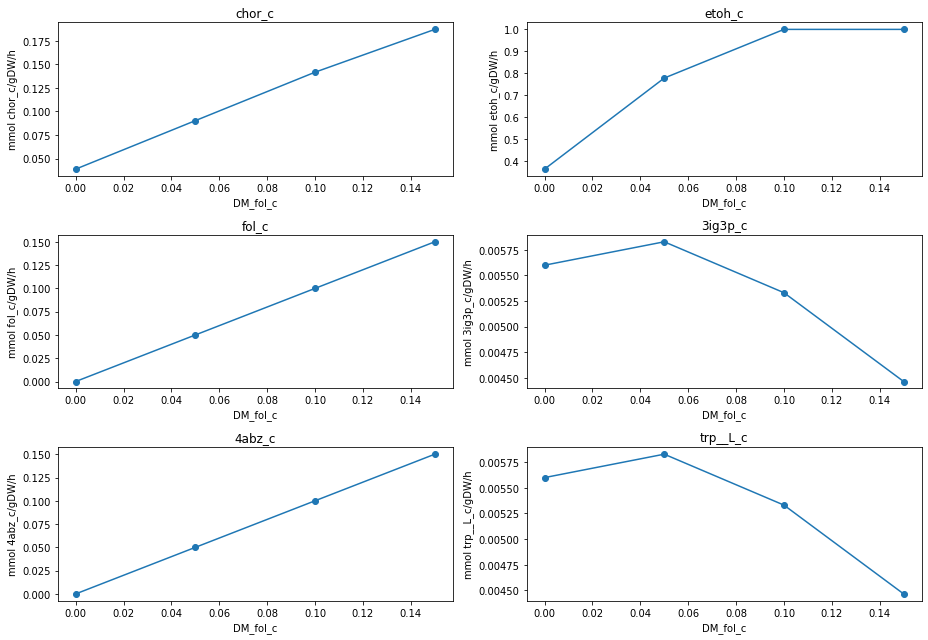

In [112]:
met_list = ['chor_c','etoh_c','fol_c','3ig3p_c','4abz_c','trp__L_c']
for met_id, met_rate,uptake_rate in get_met_production(me,met_list,flux_responses_me,'DM_fol_c'):
    r = met_rate

In [101]:
flux_based_reactions(me,'4abz_c',flux_dict=flux_responses_me['0.05'].to_dict(),only_types=['MetabolicReaction','MEReaction'])

,lb,ub,rxn_flux,met_flux,reaction
DHFS_FWD_BSU28080-MONOMER,0,999999,0.0500502,0.0500502,3.01444287398658e-6*mu BSU28080-MONOMER + atp_...
FOLR2_REV_BSU21810-MONOMER,0,999999,0.05,-0.05,4.27350427350427e-6*mu BSU21810-MONOMER + dhf_...
DHFR_FWD_BSU21810-MONOMER,0,999999,0.00656257,-0.00656257,6.01477593675738e-6*mu BSU21810-MONOMER + dhf_...
TMDS_FWD_CPLX8J2-176,0,999999,0.0065124,0.0065124,4.27350427350427e-6*mu CPLX8J2-176 + dump_c + ...
TMDS_FWD_BSU17680-MONOMER,0,999999,0,0,4.27350427350427e-6*mu BSU17680-MONOMER + dump...
TMDS_FWD_BSU21820-MONOMER_mod_mg2,0,999999,0,0,9.10884494568306e-6*mu BSU21820-MONOMER_mod_mg...
FOLR2_FWD_BSU21810-MONOMER,0,999999,0,0,4.27350427350427e-6*mu BSU21810-MONOMER + fol_...
DHFR_REV_BSU21810-MONOMER,0,999999,0,0,6.01477593675738e-6*mu BSU21810-MONOMER + nadp...


In [103]:
me.reactions.get_by_id('FOLR2_REV_BSU21810-MONOMER').

''

### Fix trp synthesis and vary ethanol

In [66]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [67]:
flux_responses_me = pd.read_csv('stress_cases/ethanol_flux_responses.csv',index_col=0)

In [68]:
# new_mu = 0.9*me.solution.f
new_mu = False
me.reactions.biomass_dilution.upper_bound = me.solution.f

In [69]:
# Ethanol can be imported through diffusion
osm_rxn = me.reactions.get_by_id('ETOHtex_FWD_SPONT')
osm_rxn.lower_bound=0
osm_rxn.upper_bound=1000
print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   

ETOHtex_FWD_SPONT 0 1000 etoh_e <=> etoh_c


In [70]:
get_reactions_of_met(me,'etoh_e')

( EX_etoh_e 0.0 999999.0 ) 	 etoh_e --> 
( ETOHtex_FWD_SPONT 0 1000 ) 	 etoh_e <=> etoh_c


[<MEReaction EX_etoh_e at 0x7f683f689ba8>,
 <MetabolicReaction ETOHtex_FWD_SPONT at 0x7f68841891d0>]

In [72]:
# Fix trp sythesis
trp_trans = flux_responses_me.loc['TRPS1_FWD_CPLX8J2-19_mod_pydx5p']['-0.0']
me.reactions.get_by_id('TRPS1_FWD_CPLX8J2-19_mod_pydx5p').lower_bound = 0
me.reactions.get_by_id('TRPS1_FWD_CPLX8J2-19_mod_pydx5p').upper_bound = trp_trans

In [73]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    me.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [74]:
etoh_rates = -np.arange(0,0.6,0.1)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me_fix = pd.DataFrame.from_dict(flux_dict)
flux_responses_me_fix = flux_responses_me_fix[sorted(flux_responses_me_fix.columns)]
flux_responses_me_fix.head()

Rates to use: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5]
Calculating with 6 cores


,-0.5,-0.4,-0.3,-0.2,-0.1,-0.0
biomass_dilution,0.101699,0.101699,0.101699,0.101699,0.101699,0.101699
protein_biomass_to_biomass,0.035602,0.035565,0.035528,0.035490,0.035453,0.035778
mRNA_biomass_to_biomass,0.000118,0.000117,0.000117,0.000117,0.000117,0.000118
tRNA_biomass_to_biomass,0.000715,0.000714,0.000714,0.000713,0.000712,0.000717
rRNA_biomass_to_biomass,0.005160,0.005157,0.005153,0.005149,0.005145,0.005185


In [75]:
# Save results
flux_responses_me_fix.to_csv('stress_cases/ethanol_fixedtrp_flux_responses.csv',index_label='rxn_id')

In [76]:
flux_responses_me_fix = pd.read_csv('stress_cases/ethanol_fixedtrp_flux_responses.csv',index_col=0)

Text(0.5, 0, 'Ethanol uptake')

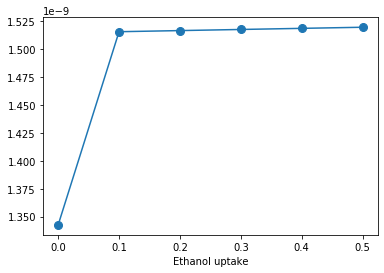

In [77]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me_fix.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me_fix.loc['EX_etoh_e'],
         expression,
         marker = 'o',markersize=8)

plt.xlabel('Ethanol uptake')

In [27]:
flux_responses_me = pd.read_csv('stress_cases/ethanol_flux_responses.csv',index_col=0)
flux_responses_me_fix = pd.read_csv('stress_cases/ethanol_fixedtrp_flux_responses.csv',index_col=0)

In [79]:
flux_responses_me_fix.loc['TRPS1_FWD_CPLX8J2-19_mod_pydx5p']

-0.5                    0.004454
-0.4                    0.004454
-0.30000000000000004    0.004454
-0.2                    0.004454
-0.1                    0.004454
-0.0                    0.004454
Name: TRPS1_FWD_CPLX8J2-19_mod_pydx5p, dtype: float64

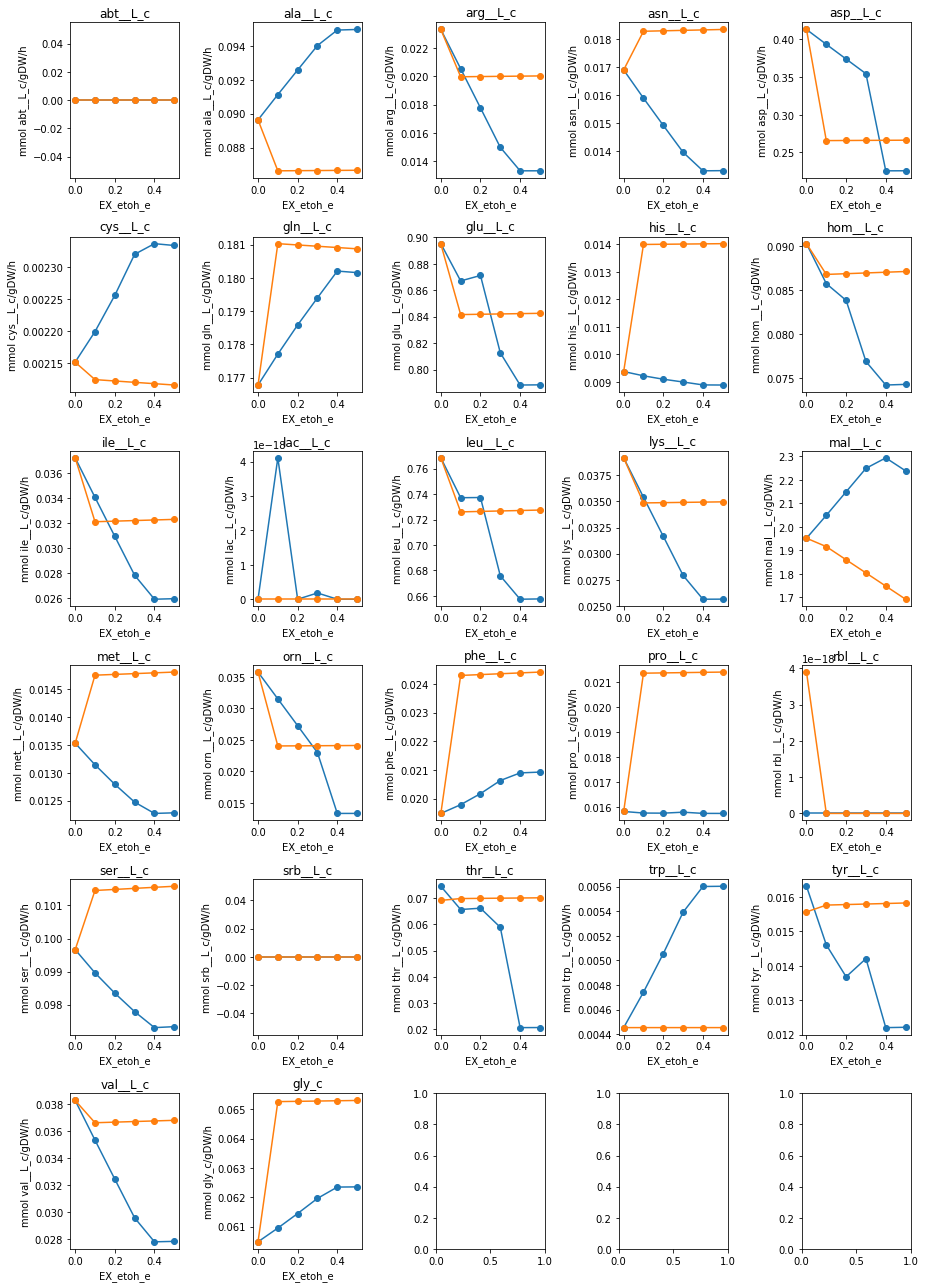

In [107]:
met_list = [m.id for m in me.metabolites if '__L_c' in m.id and isinstance(m,cobrame.Metabolite) and len(m.id)==8]
[met_list.append(m) for m in ['gly_c']]
get_met_production(me,met_list,[flux_responses_me,flux_responses_me_fix],'EX_etoh_e')
plt.savefig('figures/ethanol_aa_prod_comparison.svg',format='SVG')

### Close trp synthesis and feed trp

In [4]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [5]:
# new_mu = 0.9*me.solution.f
new_mu = False
me.reactions.biomass_dilution.upper_bound = me.solution.f

In [6]:
# Ethanol can be imported through diffusion
osm_rxn = cobrame.MEReaction('ETOHtex')
me.add_reaction(osm_rxn)

osm_rxn.add_metabolites({'etoh_e':-1,'etoh_c':1})
osm_rxn.lower_bound=0
osm_rxn.upper_bound=1000
print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   

ETOHtex 0 1000 etoh_e <=> etoh_c


In [25]:
flux_responses_me_fed.loc['biomass_dilution']

-0.5                    0.101699
-0.4                    0.101699
-0.30000000000000004    0.101699
-0.2                    0.101699
-0.1                    0.101699
-0.0                    0.101699
Name: biomass_dilution, dtype: float64

In [7]:
# Close trp sythesis
me.reactions.get_by_id('TRPS1_FWD_CPLX8J2-19_mod_pydx5p').lower_bound = 0
me.reactions.get_by_id('TRPS1_FWD_CPLX8J2-19_mod_pydx5p').upper_bound = 0

# Open trp uptake
me.reactions.get_by_id('EX_trp__L_e').lower_bound = -1000
me.reactions.get_by_id('EX_trp__L_e').upper_bound = 0

In [8]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    me.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [9]:
etoh_rates = -np.arange(0,0.6,0.1)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me_fed = pd.DataFrame.from_dict(flux_dict)
flux_responses_me_fed = flux_responses_me_fed[sorted(flux_responses_me_fed.columns)]
flux_responses_me_fed.head()

Rates to use: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5]
Calculating with 6 cores


,-0.5,-0.4,-0.3,-0.2,-0.1,-0.0
biomass_dilution,0.101699,0.101699,0.101699,0.101699,0.101699,0.101699
protein_biomass_to_biomass,0.026698,0.026673,0.027509,0.029928,0.032373,0.034870
mRNA_biomass_to_biomass,0.000095,0.000095,0.000098,0.000104,0.000111,0.000117
tRNA_biomass_to_biomass,0.000565,0.000565,0.000594,0.000633,0.000671,0.000708
rRNA_biomass_to_biomass,0.004178,0.004175,0.004286,0.004573,0.004848,0.005113


In [10]:
# Save results
flux_responses_me_fed.to_csv('stress_cases/ethanol_fedtrp_flux_responses.csv',index_label='rxn_id')

In [110]:
flux_responses_me_fed = pd.read_csv('stress_cases/ethanol_fedtrp_flux_responses.csv',index_col=0)

Text(0.5, 0, 'Ethanol uptake')

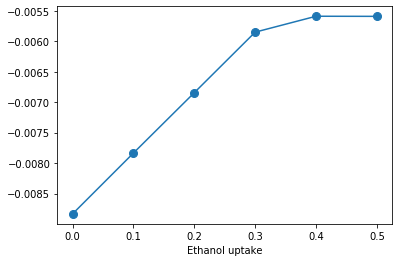

In [111]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me_fed.loc['EX_trp__L_e']
plt.plot(-flux_responses_me_fed.loc['EX_etoh_e'],
         expression,
         marker = 'o',markersize=8)

plt.xlabel('Ethanol uptake')

In [112]:
flux_based_reactions(me,'trp__L_c',flux_dict=flux_responses_me_fed['-0.0'].to_dict(),only_types=['MetabolicReaction','MEReaction'])

,lb,ub,rxn_flux,met_flux,reaction
TRPt2r_FWD_BSU10010-MONOMER,0,999999,0.00883249,0.00883249,0.000162200908237131*mu BSU10010-MONOMER + h_e...
translation_BSU25020,0,1000,0.000714517,-0.0042871,10fthf_c + 0.000858974358974359*mu BSU01120-MO...
translation_dummy,0,1000,0.0005747,-0.0017241,10fthf_c + 0.0012991452991453*mu BSU01120-MONO...
translation_BSU14900,0,1000,4.25358e-05,-0.000723109,10fthf_c + 0.00265384615384615*mu BSU01120-MON...
translation_BSU22540,0,1000,7.1628e-05,-0.000429768,10fthf_c + 0.00108547008547009*mu BSU01120-MON...
...,...,...,...,...,...
translation_BSU25710,0,1000,0,-0,10fthf_c + 0.00106410256410256*mu BSU01120-MON...
translation_BSU08450,0,1000,0,-0,10fthf_c + 0.00141880341880342*mu BSU01120-MON...
translation_BSU38240,0,1000,0,-0,10fthf_c + 0.00218803418803419*mu BSU01120-MON...
translation_BSU28140,0,1000,0,-0,10fthf_c + 0.00111538461538462*mu BSU01120-MON...


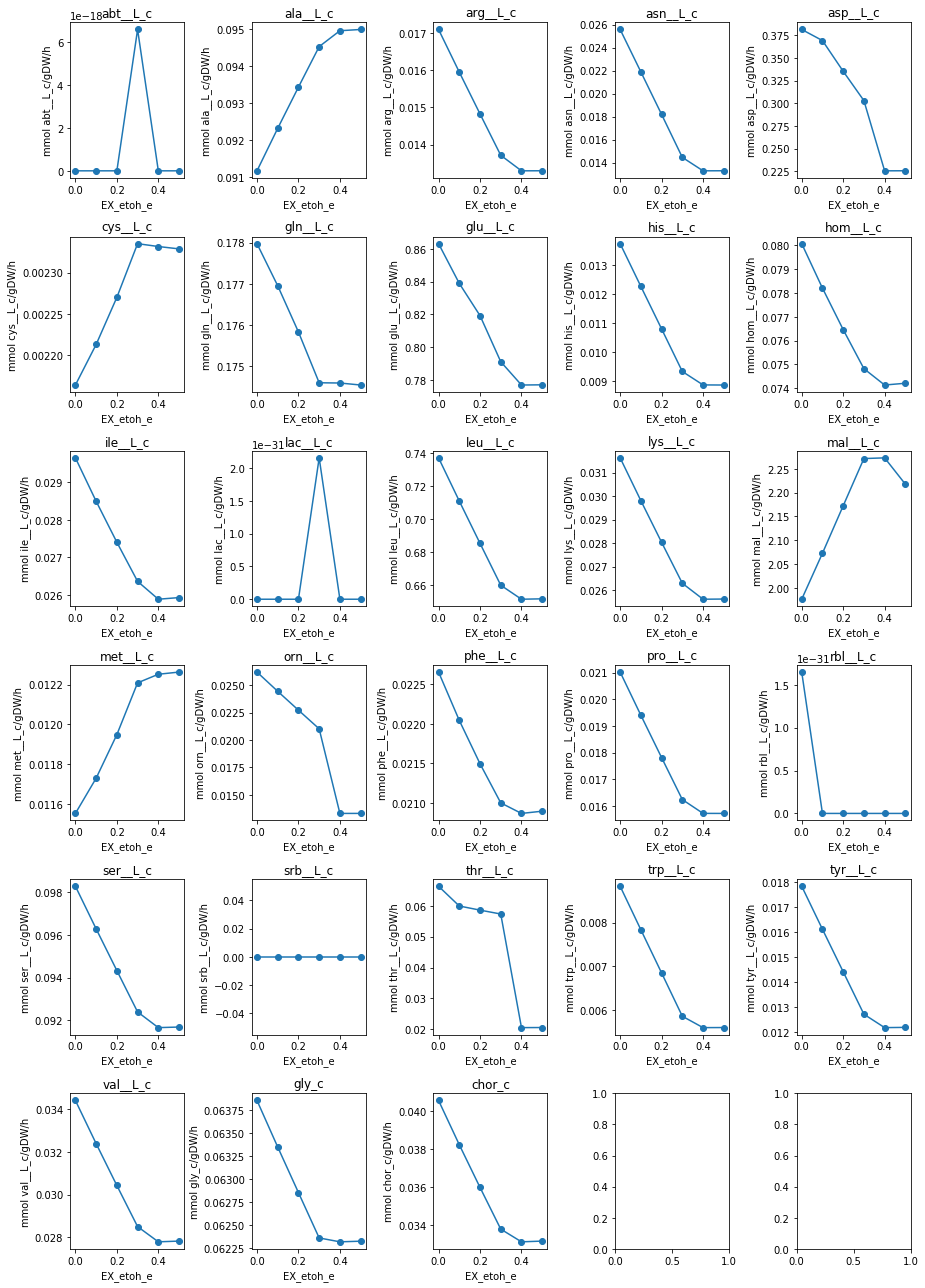

In [113]:
met_list = [m.id for m in me.metabolites if '__L_c' in m.id and isinstance(m,cobrame.Metabolite) and len(m.id)==8]
[met_list.append(m) for m in ['gly_c','chor_c']]
get_met_production(me,met_list,flux_responses_me_fed,'EX_etoh_e')

Text(0.5, 0, 'Folate damage rate')

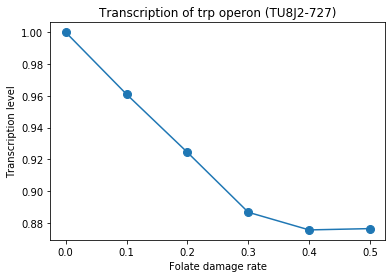

In [59]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me_fed.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me_fed.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of trp operon (TU8J2-727)')
plt.ylabel('Transcription level')
plt.xlabel('Folate damage rate')

In [30]:
flux_responses_me = pd.read_csv('stress_cases/ethanol_flux_responses.csv',index_col=0)
flux_responses_me_fix = pd.read_csv('stress_cases/ethanol_fixedtrp_flux_responses.csv',index_col=0)
flux_responses_me_fed = pd.read_csv('stress_cases/ethanol_fedtrp_flux_responses.csv',index_col=0)

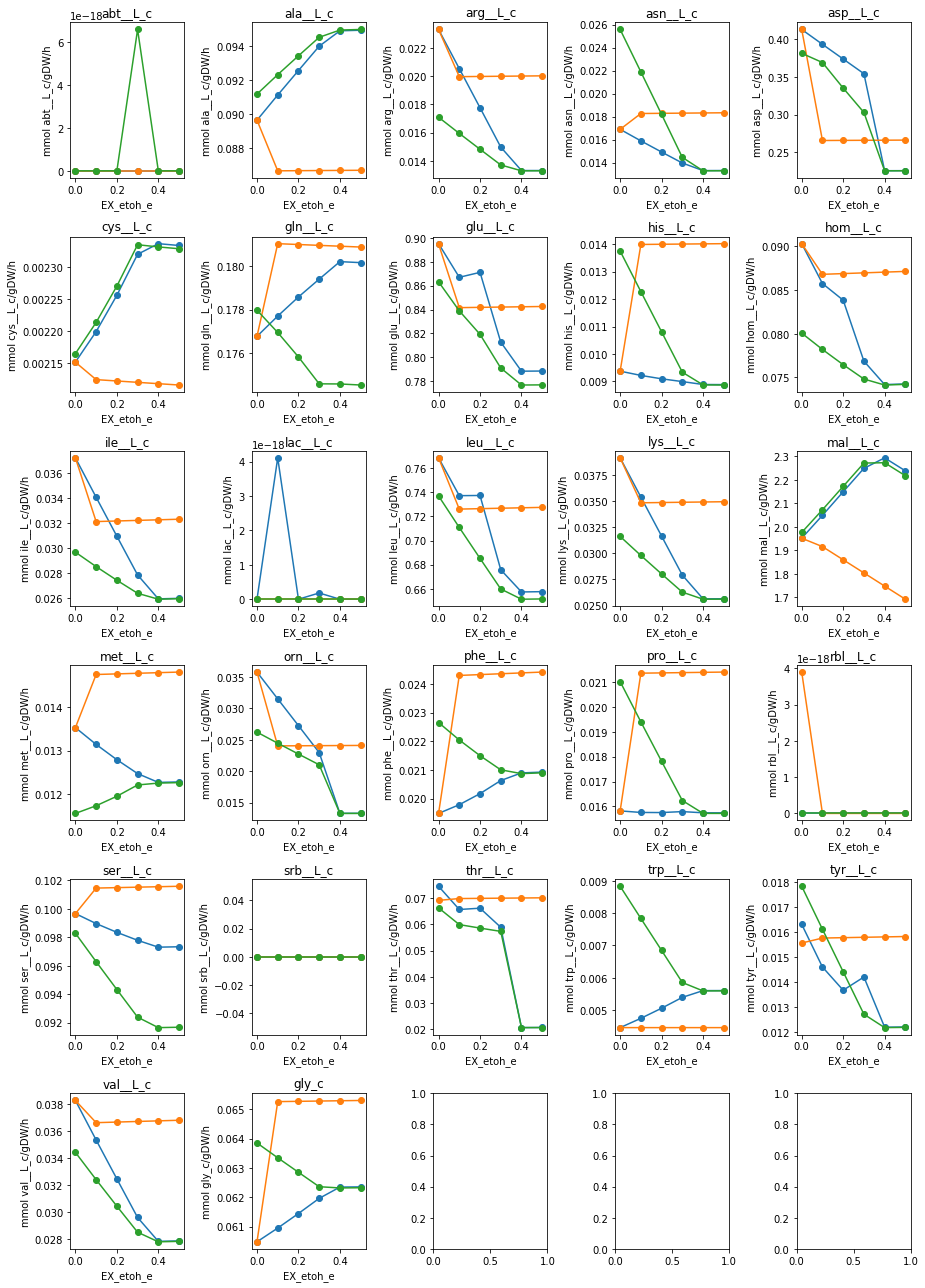

In [32]:
met_list = [m.id for m in me.metabolites if '__L_c' in m.id and isinstance(m,cobrame.Metabolite) and len(m.id)==8]
[met_list.append(m) for m in ['gly_c']]


fig,ax = plt.subplots(int(np.ceil(np.sqrt(len(met_list)))),int(np.floor(np.sqrt(len(met_list)))),figsize=(13,3*int(np.ceil(np.sqrt(len(met_list))))))
ax = ax.flatten()
x_var = 'EX_etoh_e'
temp_dict = {}
for idx,met_id in enumerate(met_list):
    temp_dict[met_id] = {}
    met_rate = []
    uptake_rate = []
    
    met_rate_fix = []
    uptake_rate_fix = []
    
    met_rate_fed = []
    uptake_rate_fed = []
    
    for idx2,case in enumerate(flux_responses_me.columns):
        df = flux_based_reactions(me,met_id,flux_dict=flux_responses_me[case].to_dict(),only_types=['MetabolicReaction'])
        met_rate.append(df[df.met_flux>0]['met_flux'].sum())
        uptake_rate.append(-flux_responses_me[case][x_var])
    for idx2,case in enumerate(flux_responses_me_fix.columns):
        df_fix = flux_based_reactions(me,met_id,flux_dict=flux_responses_me_fix[case].to_dict(),only_types=['MetabolicReaction'])
        met_rate_fix.append(df_fix[df_fix.met_flux>0]['met_flux'].sum())
        uptake_rate_fix.append(-flux_responses_me_fix[case][x_var])
    for idx3,case in enumerate(flux_responses_me_fed.columns):
        df_fed = flux_based_reactions(me,met_id,flux_dict=flux_responses_me_fed[case].to_dict(),only_types=['MetabolicReaction'])
        met_rate_fed.append(df_fed[df_fed.met_flux>0]['met_flux'].sum())
        uptake_rate_fed.append(-flux_responses_me_fed[case][x_var])
    ax[idx].plot(uptake_rate,met_rate,'-o',label='std')
    ax[idx].plot(uptake_rate_fix,met_rate_fix,'-o',label='fix')
    ax[idx].plot(uptake_rate_fed,met_rate_fed,'-o',label='fed')
    ax[idx].set_xlabel(x_var)
    ax[idx].set_ylabel('mmol {}/gDW/h'.format(met_id))
    ax[idx].set_title(met_id)
fig.tight_layout()
#plt.savefig('figures/ethanol_aa_prod_comparison.svg',format='SVG')

### Forcing folate damage and fed chor

In [81]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [82]:
me.reactions.get_by_id('EX_etoh_e').upper_bound = -0.5
me.reactions.get_by_id('EX_etoh_e').lower_bound = -1000

In [83]:
# Folate damage
r = cobrame.MEReaction('DM_fol_c')
me.add_reaction(r)

r.add_metabolites({'fol_c':-1})
r.lower_bound=0
r.upper_bound=1000
print(r.id,r.lower_bound,r.upper_bound,r.reaction)   

DM_fol_c 0 1000 fol_c <=> 


In [84]:
# Open trp uptake
me.reactions.get_by_id('EX_chor_e').lower_bound = -1000
me.reactions.get_by_id('EX_chor_e').upper_bound = 0

In [85]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('DM_fol_c').lower_bound = rate
    me.reactions.get_by_id('DM_fol_c').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [86]:
etoh_rates = np.arange(0,0.2,0.05)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()


Rates to use: [0.   0.05 0.1  0.15]
Calculating with 4 cores


,0.00,0.05,0.10,0.15
biomass_dilution,0.233559,0.224546,0.215490,0.206443
protein_biomass_to_biomass,0.080237,0.077257,0.074255,0.071249
mRNA_biomass_to_biomass,0.000337,0.000319,0.000303,0.000286
tRNA_biomass_to_biomass,0.001994,0.001892,0.001792,0.001694
rRNA_biomass_to_biomass,0.014734,0.013983,0.013244,0.012519


In [93]:
# Save results
flux_responses_me.to_csv('stress_cases/folate_fedchor_flux_responses.csv',index_label='rxn_id')

In [153]:
flux_responses_me = pd.read_csv('stress_cases/folate_fedchor_flux_responses.csv',index_col=0)

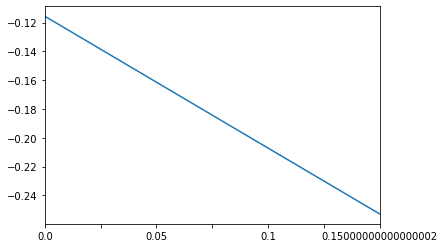

In [154]:
flux_responses_me.loc['EX_chor_e'].plot()

IndexError: index 2 is out of bounds for axis 0 with size 2

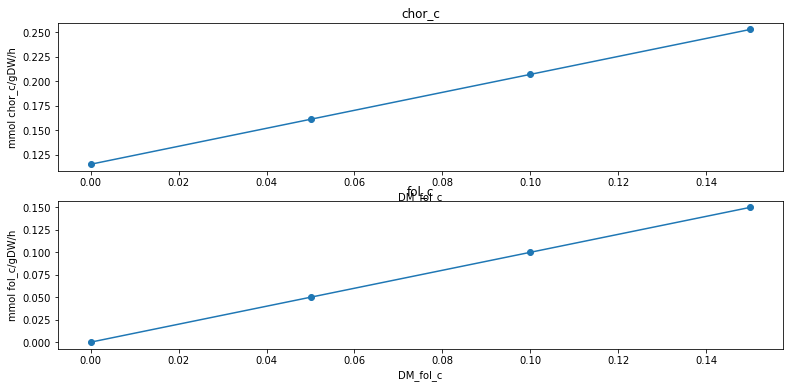

In [157]:
met_list = ['chor_c','fol_c','trp__L_c']
get_met_production(me,met_list,flux_responses_me,'DM_fol_c')

In [109]:
get_reactions_of_met(me,'chor_e')

( EX_chor_e -1000 0 ) 	 chor_e <=> 
( CHORt2_FWD_CPLX_dummy 0 999999.0 ) 	 4.27350427350427e-6*mu CPLX_dummy + chor_e + h_e <=> chor_c + h_c
( CHORt2_REV_CPLX_dummy 0 999999.0 ) 	 4.27350427350427e-6*mu CPLX_dummy + chor_c + h_c <=> chor_e + h_e


[<MEReaction EX_chor_e at 0x7f46e2328c88>,
 <MetabolicReaction CHORt2_FWD_CPLX_dummy at 0x7f471e95ac88>,
 <MetabolicReaction CHORt2_REV_CPLX_dummy at 0x7f471e95ab70>]

Text(0.5, 0, 'Folate damage rate')

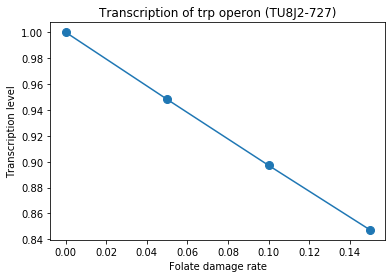

In [91]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(flux_responses_me.loc['DM_fol_c'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of trp operon (TU8J2-727)')
plt.ylabel('Transcription level')
plt.xlabel('Folate damage rate')

In [163]:
get_reactions_of_met(me,'chor_c',s=1)

( CHORt2_FWD_CPLX_dummy 0 999999.0 ) 	 4.27350427350427e-6*mu CPLX_dummy + chor_e + h_e <=> chor_c + h_c
( ICHORS_REV_BSU30830-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU30830-MONOMER + ichor_c <=> chor_c
( CHORS_FWD_BSU22710-MONOMER 0 999999.0 ) 	 3psme_c + 1.18913762224876e-5*mu BSU22710-MONOMER <=> chor_c + pi_c
( ICHORS_REV_BSU31990-MONOMER_mod_mg2 0 999999.0 ) 	 3.25782676110195e-6*mu BSU31990-MONOMER_mod_mg2 + ichor_c <=> chor_c


[<MetabolicReaction CHORt2_FWD_CPLX_dummy at 0x7f471e95ac88>,
 <MetabolicReaction ICHORS_REV_BSU30830-MONOMER at 0x7f471a6886d8>,
 <MetabolicReaction CHORS_FWD_BSU22710-MONOMER at 0x7f471e95a710>,
 <MetabolicReaction ICHORS_REV_BSU31990-MONOMER_mod_mg2 at 0x7f471a688128>]

In [161]:
me.metabolites.get_by_id('dhf_c').name

'7,8-Dihydrofolate'

### Close acetate secretion

In [5]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [6]:
# new_mu = 0.9*me.solution.f
new_mu = False
me.reactions.biomass_dilution.upper_bound = me.solution.f

In [7]:
# Ethanol can be imported through diffusion
osm_rxn = cobrame.MEReaction('ETOHtex')
me.add_reaction(osm_rxn)

osm_rxn.add_metabolites({'etoh_e':-1,'etoh_c':1})
osm_rxn.lower_bound=0
osm_rxn.upper_bound=1000
print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   

ETOHtex 0 1000 etoh_e <=> etoh_c


In [8]:
# Close acetate secretion
me.reactions.get_by_id('ACt2r_REV_BSU38240-MONOMER').lower_bound = 0
me.reactions.get_by_id('ACt2r_REV_BSU38240-MONOMER').upper_bound = 0

In [170]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    me.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [172]:
etoh_rates = -np.arange(0,0.6,0.1)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me_noacsec = pd.DataFrame.from_dict(flux_dict)
flux_responses_me_noacsec = flux_responses_me_noacsec[sorted(flux_responses_me_noacsec.columns)]
flux_responses_me_noacsec.head()

Rates to use: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5]
Calculating with 6 cores


,-0.5,-0.4,-0.3,-0.2,-0.1,-0.0
biomass_dilution,0.101699,0.101699,0.101699,0.101699,0.101699,0.101699
protein_biomass_to_biomass,0.026735,0.026710,0.028246,0.030720,0.033221,0.035778
mRNA_biomass_to_biomass,0.000096,0.000095,0.000100,0.000106,0.000112,0.000118
tRNA_biomass_to_biomass,0.000566,0.000565,0.000605,0.000644,0.000681,0.000717
rRNA_biomass_to_biomass,0.004181,0.004178,0.004372,0.004654,0.004924,0.005185


In [173]:
# Save results
flux_responses_me_noacsec.to_csv('stress_cases/ethanol_noacsec_flux_responses.csv',index_label='rxn_id')

In [9]:
flux_responses_me_noacsec = pd.read_csv('stress_cases/ethanol_noacsec_flux_responses.csv',index_col=0)

Text(0.5, 0, 'Ethanol uptake rate')

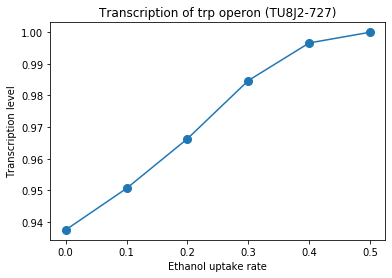

In [10]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me_noacsec.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me_noacsec.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of trp operon (TU8J2-727)')
plt.ylabel('Transcription level')
plt.xlabel('Ethanol uptake rate')

In [12]:
flux_based_reactions(me,'trp__L_c',flux_dict=flux_responses_me_noacsec['-0.0'].to_dict(),only_types=['MetabolicReaction','MEReaction'])

,lb,ub,rxn_flux,met_flux,reaction
TRPS1_FWD_CPLX8J2-19_mod_pydx5p,0,999999,0.00445414,0.00445414,3ig3p_c + 4.73113259594653e-6*mu CPLX8J2-19_mo...
translation_dummy,0,1000,0.000589649,-0.00176895,10fthf_c + 0.0012991452991453*mu BSU01120-MONO...
translation_BSU14900,0,1000,4.02809e-05,-0.000684775,10fthf_c + 0.00265384615384615*mu BSU01120-MON...
translation_BSU22540,0,1000,6.78308e-05,-0.000406985,10fthf_c + 0.00108547008547009*mu BSU01120-MON...
translation_BSU22550,0,1000,6.78308e-05,-0.000406985,10fthf_c + 0.000952991452991453*mu BSU01120-MO...
...,...,...,...,...,...
translation_BSU39920,0,1000,0,-0,10fthf_c + 0.00318803418803419*mu BSU01120-MON...
translation_BSU01630,0,1000,0,-0,10fthf_c + 0.00135042735042735*mu BSU01120-MON...
translation_BSU36120,0,1000,0,-0,10fthf_c + 0.000837606837606838*mu BSU01120-MO...
translation_BSU35950,0,1000,0,-0,10fthf_c + 0.00137179487179487*mu BSU01120-MON...


In [11]:
get_reactions_of_met(me,'trp__L_c',only_types=['MetabolicReaction'])

( LAAL33_FWD_BSU37710-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU37710-MONOMER + ala__L_c + atp_c + trp__L_c <=> adp_c + ala_L_trp__L_c + h_c + pi_c
( LAAL34_FWD_BSU37710-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU37710-MONOMER + atp_c + ser__L_c + trp__L_c <=> adp_c + h_c + pi_c + ser_L_trp__L_c
( TRPt2r_FWD_BSU10010-MONOMER 0 999999.0 ) 	 0.000162200908237131*mu BSU10010-MONOMER + h_e + trp__L_e <=> h_c + trp__L_c
( BIOMASS_BS_10_FWD_CPLX_dummy 0 0 ) 	 0.000367 10fthf_c + 4.27350427350427e-6*mu CPLX_dummy + 0.266902 ala__L_c + 0.00467 amp_c + 0.193021 arg__L_c + 0.147987 asn__L_c + 0.148014 asp__L_c + 105.053483 atp_c + 0.003205 ca2_c + 5e-06 cdlp_BS_c + 0.000251 cdp_c + 0.001042 cmp_c + 0.038902 ctp_c + 0.05699 cys__L_c + 0.00011 d12dg_BS_c + 0.022982 datp_c + 0.01738 dctp_c + 0.017398 dgtp_c + 0.022899 dttp_c + 0.00345 fe3_c + 0.00018 gdp_c + 0.260335 gln__L_c + 0.260378 glu__L_c + 0.408288 gly_c + 0.000503 gmp_c + 0.003624 gtca1_45_BS_c + 0.002347 gtca2_45_BS_c + 0.001

[<MetabolicReaction LAAL33_FWD_BSU37710-MONOMER at 0x7faca0819080>,
 <MetabolicReaction LAAL34_FWD_BSU37710-MONOMER at 0x7faca0819240>,
 <MetabolicReaction TRPt2r_FWD_BSU10010-MONOMER at 0x7faca05c1828>,
 <MetabolicReaction BIOMASS_BS_10_FWD_CPLX_dummy at 0x7faca0bfaba8>,
 <MetabolicReaction TRPS1_FWD_CPLX8J2-19_mod_pydx5p at 0x7faca05c15f8>]


100%|██████████| 4/4 [08:00<00:00, 120.01s/it][A


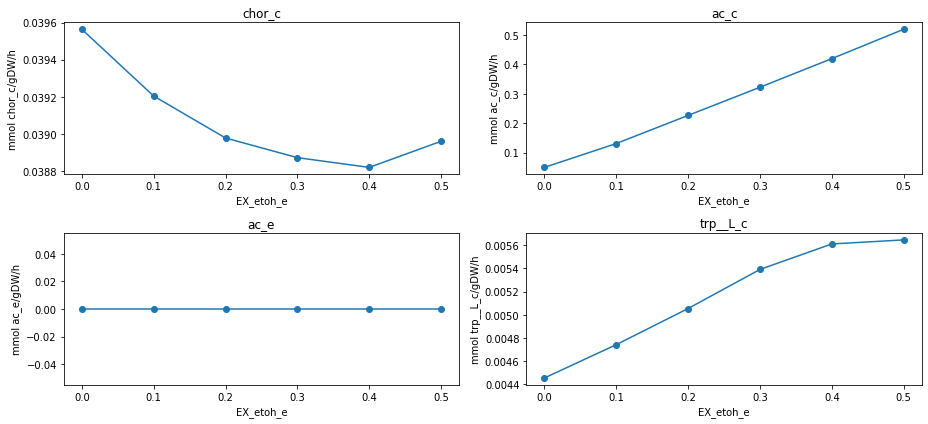

In [18]:
met_list = []
[met_list.append(m) for m in ['chor_c','ac_c','ac_e','trp__L_c']]
get_met_production(me,met_list,[flux_responses_me_noacsec],'EX_etoh_e')